## Modules


In [1]:
# Libraries
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from typing import List, Optional
from vertexai.language_models import TextEmbeddingInput, TextEmbeddingModel
from tqdm import tqdm
import time
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,mean_absolute_error, make_scorer
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier
import optuna
import xgboost as xgb


**STUDENT1_ID:** 17306259, Alexis \
**STUDENT2_ID:** 07817257, Achraf \
**STUDENT3_ID:** 18329797, Fabian \
**STUDENT4_ID:** 18807297, Ezgi \
**STUDENT5_ID:** 13822853, Kyril 

## Data


### Description of data

Reviews Dataset:

- id - numerical index, the unique observation index for the given dataset
- rating (training set only) - categorical, business satisfaction rating: 1, 2, 3, 4, 5 (1: worse, 5: best)
- text - string, the review text itself
- business_id - string, unique business identifier
- user_id - string, unique customer identifier
- useful - integer, number of useful votes received
- funny - integer, number of funny votes received
- cool - integer, number of cool votes received
- date - string, date formatted YYYY-MM-DD

Businesses Dataset:

- business_id - string, unique business identifier
- name - string, the business's name
- address - string, the full address of the business
- city - string, the city
- state - string, 2 character state code, if applicable
- postal_code - string, the postal code
- latitude - float, latitude
- longitude - float, longitude
- attributes - object, business attributes to values. note: some attribute values might be objects
- categories - an array of strings of business categories
- hours - an object of key day to value hours, hours are using a 24hr clock

Customers Dataset:

- user_id - string, unique customer identifier
- name - string, the customer's first name
- ser_since - string, when the customer started rating businesses YYYY-MM-DD
- useful - integer, number of useful votes sent by the customer
- funny - integer, number of funny votes sent by the customer
- cool - integer, number of cool votes sent by the customer
- premium_account - array of integers, the years the customer had a premium account thanks to his involvement in writing reviews
- friends - integer, number of friends the customer has on the rating platform
- fans - integer, number of fans the customer has on the rating platform
- compliment_hot - integer, number of hot compliments received by the customer
- compliment_more - integer, number of more compliments received by the customer
- compliment_profile - integer, number of profile compliments received by the customer
- compliment_cute - integer, number of cute compliments received by the customer
- compliment_list - integer, number of list compliments received by the customer
- compliment_note - integer, number of note compliments received by the customer
- compliment_plain - integer, number of plain compliments received by the customer
- compliment_cool - integer, number of cool compliments received by the customer
- compliment_funny - integer, number of funny compliments received by the customer
- compliment_writer - integer, number of writer compliments received by the customer


In [2]:
# Import data
df_business = pd.read_parquet("data/ATML2024_businesses.parquet")

df_Train_reviews = pd.read_parquet("data/ATML2024_reviews_train.parquet")

df_users = pd.read_parquet("data/ATML2024_users.parquet")

In [3]:
# General information on the datasets
# USER DATASET
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747468 entries, 0 to 747467
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   user_id             747468 non-null  object 
 1   name                747457 non-null  object 
 2   user_since          747468 non-null  object 
 3   useful              747468 non-null  float64
 4   funny               747468 non-null  float64
 5   cool                747468 non-null  float64
 6   premium_account     57420 non-null   object 
 7   friends             747468 non-null  float64
 8   fans                747468 non-null  float64
 9   compliment_hot      747468 non-null  float64
 10  compliment_more     747468 non-null  float64
 11  compliment_profile  747468 non-null  float64
 12  compliment_cute     747468 non-null  float64
 13  compliment_list     747468 non-null  float64
 14  compliment_note     747468 non-null  float64
 15  compliment_plain    747468 non-nul

In [4]:
print(df_Train_reviews.select_dtypes(include=["object", "category"]).columns.tolist())
df_users.head()

['user_id', 'business_id', 'text', 'date']


,user_id,name,user_since,useful,funny,cool,premium_account,friends,fans,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer
0,w7IdXgBVXKjZS5UYDO8cVq,Walker,2007-01-25 16:47:26,7217.0,1259.0,5994.0,2007,14995.0,267.0,250.0,65.0,55.0,56.0,18.0,232.0,844.0,467.0,467.0,239.0
1,gJrXd1wa1EZ2-_UoRgW41j,Daniel,2009-01-25 04:35:42,43091.0,13066.0,27281.0,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...",4646.0,3138.0,1145.0,264.0,184.0,157.0,251.0,1847.0,7054.0,3131.0,3131.0,1521.0
2,gvz2VtPxToEXh0KFQYXnW2,Steph,2008-07-25 10:41:00,2086.0,1010.0,1003.0,"2009,2010,2011,2012,2013",381.0,52.0,89.0,13.0,10.0,17.0,3.0,66.0,96.0,119.0,119.0,35.0
3,AIdshsLNMm50o7qXSAeDZS,Gwen,2005-11-29 04:38:33,512.0,330.0,299.0,"2009,2010,2011",131.0,28.0,24.0,4.0,1.0,6.0,2.0,12.0,16.0,26.0,26.0,10.0
4,QGFh-RoJ4HscnnE-yMl5Ah,Karen,2007-01-05 19:40:59,29.0,15.0,7.0,None,27.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [5]:
df_users = df_users.apply(
    lambda x: x.astype(int) if x.dtype == "float64" else x
)  # Convert float to int

In [6]:
# REVIEWS DATASET
df_Train_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050000 entries, 0 to 1049999
Data columns (total 9 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   id           1050000 non-null  int64 
 1   user_id      1050000 non-null  object
 2   business_id  1050000 non-null  object
 3   rating       1050000 non-null  int64 
 4   useful       1050000 non-null  int64 
 5   funny        1050000 non-null  int64 
 6   cool         1050000 non-null  int64 
 7   text         1050000 non-null  object
 8   date         1050000 non-null  object
dtypes: int64(5), object(4)
memory usage: 72.1+ MB


In [7]:
# List of categorical variables
print(df_Train_reviews.select_dtypes(include=["object", "category"]).columns.tolist())
df_Train_reviews.head()

['user_id', 'business_id', 'text', 'date']


,id,user_id,business_id,rating,useful,funny,cool,text,date
0,0,gRWsscMiClFGIh2YUjNInT,Ab1ejQzv4eJRLgAlj7tzKT,5,1,0,0,"Sometimes you just want a cup of coffee, in a ...",2013-12-22 23:45:01
1,1,Q3RXWVFtLo4I7MC85ELPh7,QkRhOowLAGVZC5gn4RLkjH,5,1,0,0,Mr. Clyde stopped at our house and asked us if...,2020-02-11 01:00:32
2,2,AD2z6qhmVcRJkywa1KsEFG,ADWVkizi8gKjj07mn8NiMe,4,0,0,0,One of my favorite places to grab a quick bit ...,2014-05-28 19:05:26
3,3,A8HQot2boCpoPIThfHV5iy,wkk30dWY49cSiDU3FKg8FH,5,0,1,0,"Wow, this place is huge! Life size aquarium an...",2014-01-20 23:42:44
4,4,Q7UzjD01YnimUOsvAEQ7JK,wUjnssL0bJIEqdqJs8M0GV,5,0,0,0,I ordered 3 large pizzas and wings for my fam...,2020-01-29 00:20:34


In [8]:
# BUSINESS DATASET
df_business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138210 entries, 0 to 138209
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   business_id  138210 non-null  object 
 1   name         138210 non-null  object 
 2   address      133772 non-null  object 
 3   city         138210 non-null  object 
 4   state        138210 non-null  object 
 5   postal_code  138145 non-null  object 
 6   latitude     138210 non-null  float64
 7   longitude    138210 non-null  float64
 8   attributes   126589 non-null  object 
 9   categories   138136 non-null  object 
 10  hours        117852 non-null  object 
dtypes: float64(2), object(9)
memory usage: 11.6+ MB


In [9]:
# List of categorical variables
print(df_Train_reviews.select_dtypes(include=["object", "category"]).columns.tolist())
df_business.head()

['user_id', 'business_id', 'text', 'date']


,business_id,name,address,city,state,postal_code,latitude,longitude,attributes,categories,hours
0,wPYArZCy3AETdTjB-x3fpm,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
1,QQNIWVsnAT_iKiKriWrFUt,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
2,wm9eoqjytVbC7dQcM4WSTM,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
3,AfVDXGIKBUE0EdTw_6cMWm,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."
4,QjvanH64QUduo6E-8F33FC,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '..."


### Merging the datasets


In [10]:
# Assessing columns with the same name
print(
    f"Column(s) name(s) present in user and business: {set(df_users.columns).intersection(set(df_business.columns))}"
)
print(
    f"Column(s) name(s) present in user and reviews: {set(df_users.columns).intersection(set(df_Train_reviews.columns))}"
)
print(
    f"Column(s) name(s) present in business and reviews: {set(df_business.columns).intersection(set(df_Train_reviews.columns))}"
)

Column(s) name(s) present in user and business: {'name'}
Column(s) name(s) present in user and reviews: {'funny', 'useful', 'cool', 'user_id'}
Column(s) name(s) present in business and reviews: {'business_id'}


In [11]:
df_users.rename(
    columns={
        "name": "user_name",
        "useful": "useful_user",
        "funny": "funny_user",
        "cool": "cool_user",
    },
    inplace=True,
)
df_business.rename(columns={"name": "business_name"}, inplace=True)
df_Train_reviews.rename(
    columns={"useful": "useful_review", "funny": "funny_review", "cool": "cool_review"},
    inplace=True,
)

In [12]:
# Assessing the number of obersevations that will be lost if we merge the datasets
print(
    f"Number of user ids not in the reviews dataset: {len(set(df_users.user_id).difference(set(df_Train_reviews.user_id)))}"
)
user_not_in_users_df = set(df_Train_reviews.user_id).difference(set(df_users.user_id))
print(f"Number of user ids not in the user dataset: {len(user_not_in_users_df)}")
print(
    f"Number of business ids not in the reviews dataset: {len(set(df_business.business_id).difference(set(df_Train_reviews.business_id)))}"
)
print(
    f"Number of business ids not in the business dataset: {len(set(df_Train_reviews.business_id).difference(set(df_business.business_id)))}"
)

Number of user ids not in the reviews dataset: 168432
Number of user ids not in the user dataset: 7
Number of business ids not in the reviews dataset: 9803
Number of business ids not in the business dataset: 0


In [13]:
# Merge the datasets
merged_reviews = pd.merge(
    pd.merge(df_Train_reviews, df_users, on="user_id", how="inner"),
    df_business,
    on="business_id",
    how="inner",
)
# Remove the columns that are not useful
merged_reviews.drop(columns=["id", "user_id", "business_id"], inplace=True)
merged_reviews.reset_index(drop=True, inplace=True)
merged_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1049993 entries, 0 to 1049992
Data columns (total 34 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   rating              1049993 non-null  int64  
 1   useful_review       1049993 non-null  int64  
 2   funny_review        1049993 non-null  int64  
 3   cool_review         1049993 non-null  int64  
 4   text                1049993 non-null  object 
 5   date                1049993 non-null  object 
 6   user_name           1049981 non-null  object 
 7   user_since          1049993 non-null  object 
 8   useful_user         1049993 non-null  int32  
 9   funny_user          1049993 non-null  int32  
 10  cool_user           1049993 non-null  int32  
 11  premium_account     258797 non-null   object 
 12  friends             1049993 non-null  int32  
 13  fans                1049993 non-null  int32  
 14  compliment_hot      1049993 non-null  int32  
 15  compliment_more

In [14]:
print(
    f"Loss of observations: {len(df_Train_reviews) - len(merged_reviews)} obersevations"
)  # user_ids that were not in the user dataset

Loss of observations: 7 obersevations


In [15]:
# Memory optimization
del df_Train_reviews, df_users, df_business

## EDA & Cleaning


### Checking for missing values


<Axes: >

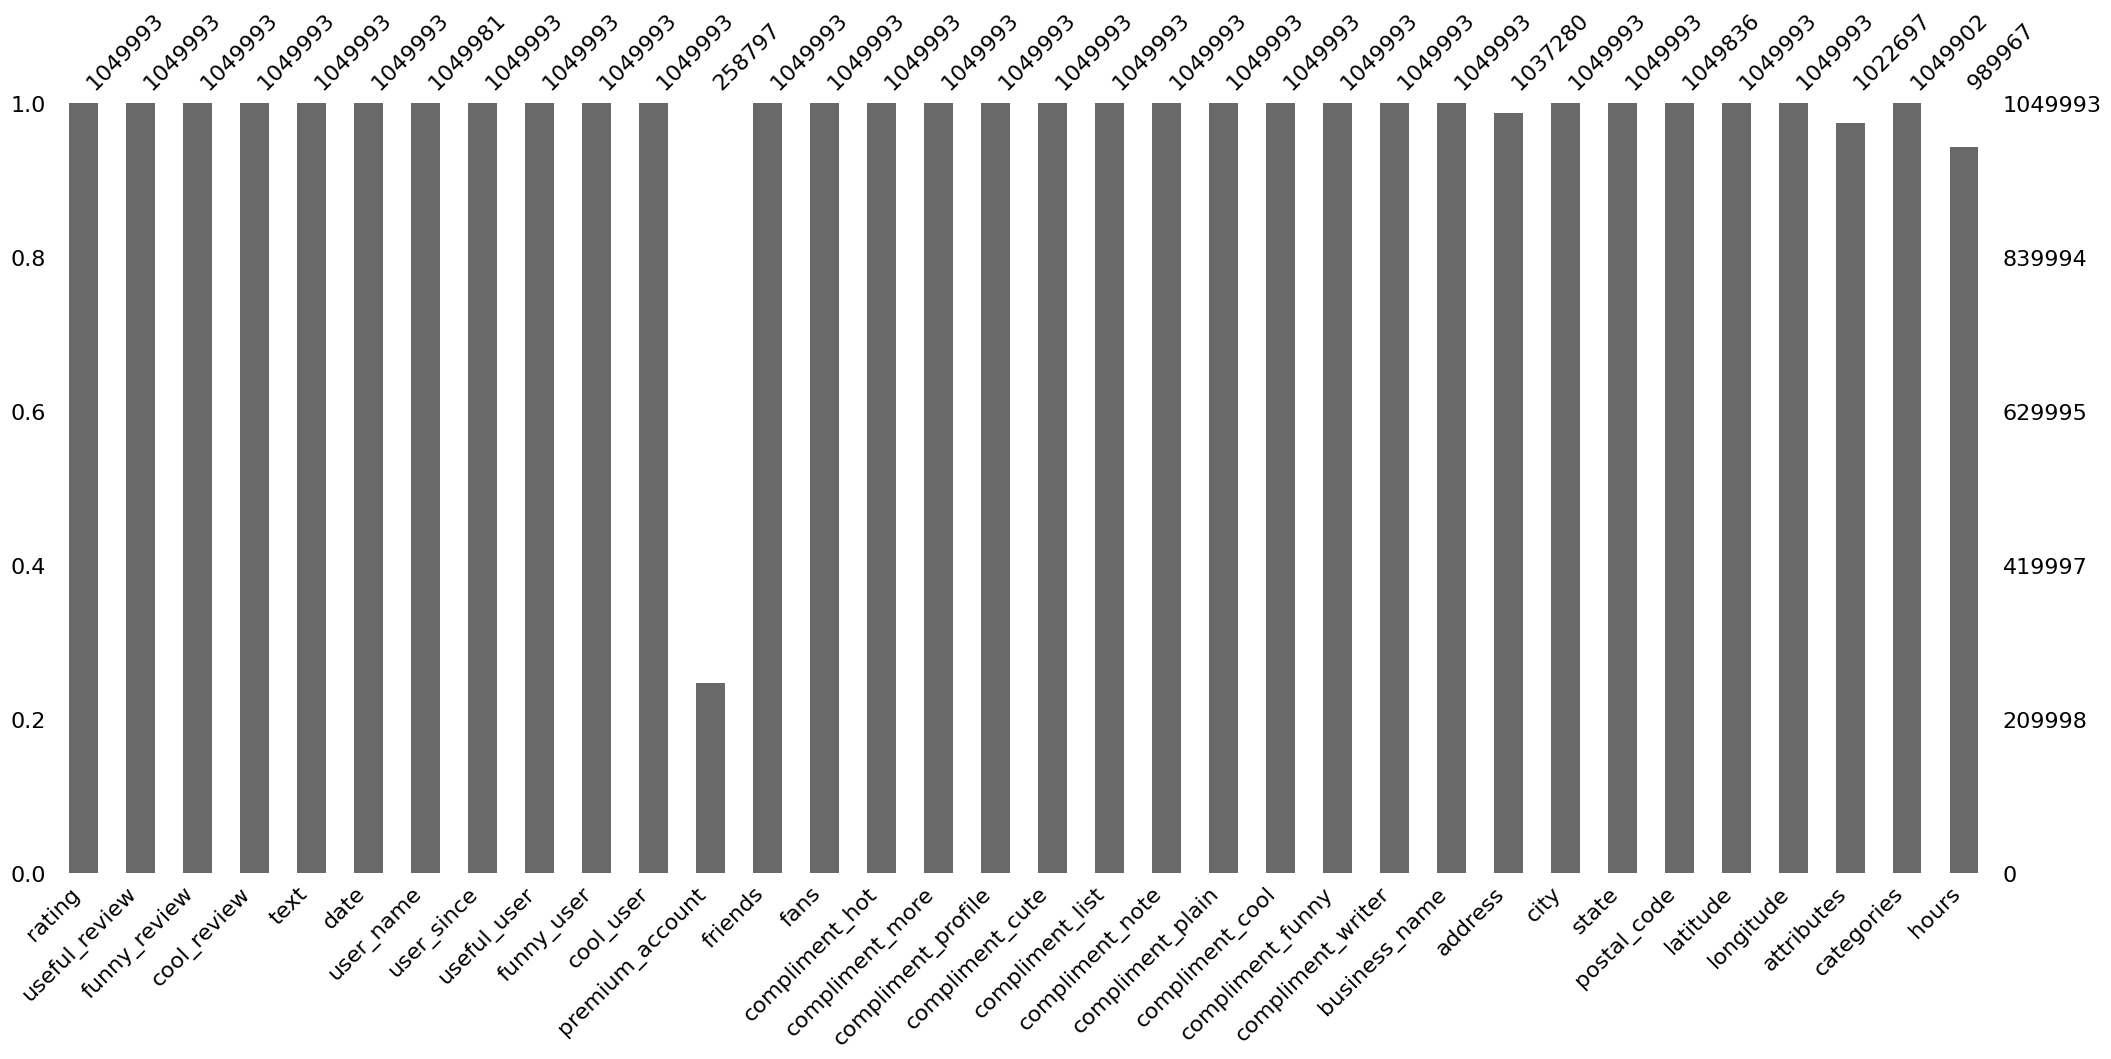

In [16]:
msno.bar(merged_reviews)

<Axes: >

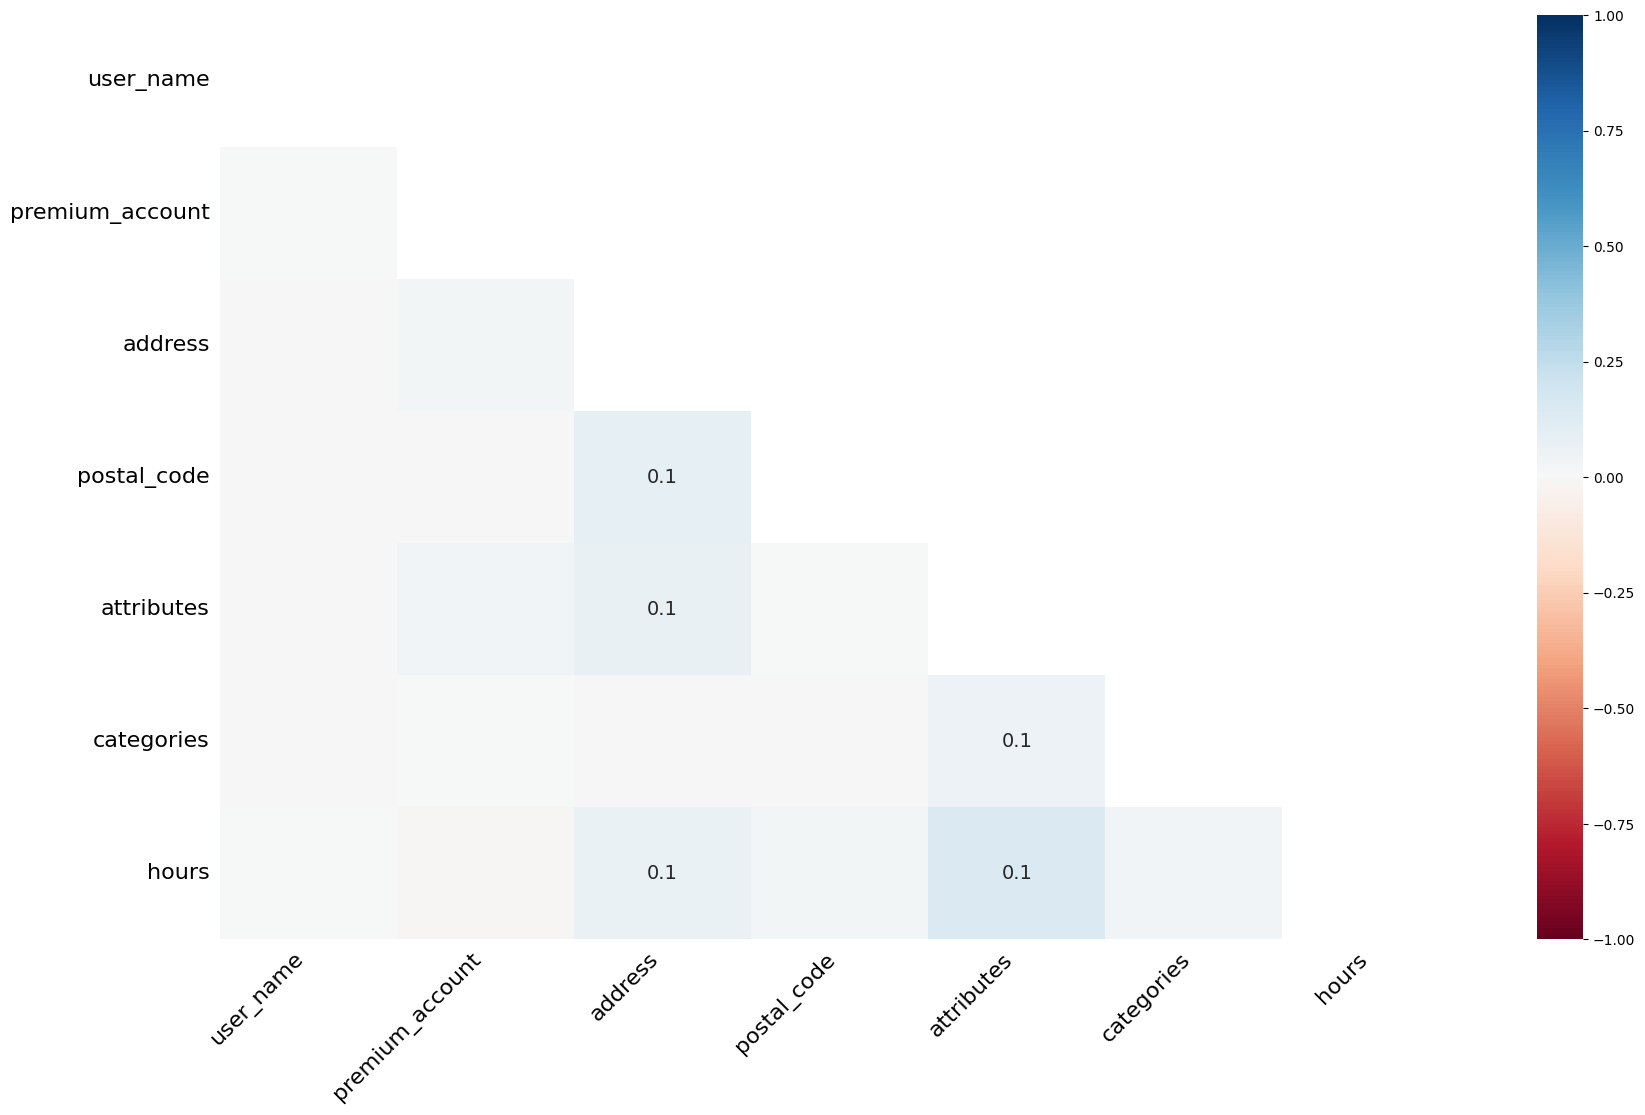

In [17]:
msno.heatmap(merged_reviews)

There is a vast majority of missing values for the variable premium_account, so we will discard it. There are uncorellated missing values for the variables user_name, address, postal_code, attributes, categories and hours. However, not that many are missing as we can see from the barplots. We will either remove these variables if we can consider them to be of low importance or simply drop observations with missing values if these variables hold value.


In [18]:
del merged_reviews["premium_account"]

### Basic Cleaning


In [19]:
merged_reviews.drop_duplicates(inplace=True)  # Removing duplicates


def sort_string_elements(
    input_string,
):  # Allows to reduct the number of distinct values
    if pd.isna(input_string):
        return input_string  # Handle NaN or None values
    elements = input_string.split(", ")
    sorted_elements = sorted(elements)
    return ", ".join(sorted_elements)


merged_reviews.categories = merged_reviews.categories.apply(sort_string_elements)

In [20]:
# Check for newline characters
new_line_indices = merged_reviews[
    merged_reviews["text"].str.contains("\n", na=False)
].index
print(len(new_line_indices))
# Check for non-standard printable ASCII characters
acii_indices = merged_reviews[
    merged_reviews["text"].str.contains("[^ -~]", na=False)
].index
print(len(acii_indices))
#
len(merged_reviews[merged_reviews["text"].str.contains("[\n\r\t]", na=False)])

363286
373566


363287

### Summary statistics


In [21]:
merged_reviews.iloc[:, :17].describe()

,rating,useful_review,funny_review,cool_review,useful_user,funny_user,cool_user,friends,fans,compliment_hot,compliment_more,compliment_profile,compliment_cute
count,1.049993e+06,1.049993e+06,1.049993e+06,1.049993e+06,1.049993e+06,1.049993e+06,1.049993e+06,1.049993e+06,1.049993e+06,1.049993e+06,1.049993e+06,1.049993e+06,1.049993e+06
mean,3.746192e+00,1.183541e+00,3.266965e-01,4.975738e-01,4.274387e+02,1.751910e+02,2.894503e+02,1.218077e+02,1.326900e+01,1.676652e+01,2.340831e+00,1.533547e+00,9.832532e-01
std,1.479860e+00,3.298680e+00,1.671896e+00,2.192192e+00,3.203843e+03,1.975387e+03,2.742284e+03,4.058908e+02,9.121500e+01,2.017517e+02,2.948550e+01,3.792296e+01,2.263179e+01
min,1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.900000e+01,3.000000e+00,4.000000e+00,1.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,5.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.100000e+02,2.400000e+01,3.900000e+01,1.090000e+02,4.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,5.000000e+00,9.330000e+02,3.750000e+02,3.760000e+02,2.062960e+05,1.858230e+05,1.998780e+05,1.499500e+04,1.249700e+04,2.578400e+04,1.350100e+04,1.418000e+04,1.365400e+04


In [22]:
merged_reviews.iloc[:, 17:].describe()

,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,latitude,longitude
count,1.049993e+06,1.049993e+06,1.049993e+06,1.049993e+06,1.049993e+06,1.049993e+06,1.049993e+06,1.049993e+06
mean,6.594520e-01,1.607275e+01,4.385474e+01,3.000955e+01,3.000955e+01,1.100755e+01,3.595539e+01,-8.974921e+01
std,1.982869e+01,1.755515e+02,5.548861e+02,3.243179e+02,3.243179e+02,1.101384e+02,5.349671e+00,1.490491e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.755826e+01,-1.200951e+02
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.996479e+01,-9.030558e+01
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.860502e+01,-8.621821e+01
75%,0.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,2.000000e+00,3.994312e+01,-7.549685e+01
max,1.266900e+04,5.903100e+04,1.010970e+05,4.996700e+04,4.996700e+04,1.593400e+04,5.367920e+01,-7.320046e+01


useful_review shouldn't be negative.


In [23]:
merged_reviews = merged_reviews[
    merged_reviews.useful_review >= 0
]  # Removing the anomalies

### Scatter plots


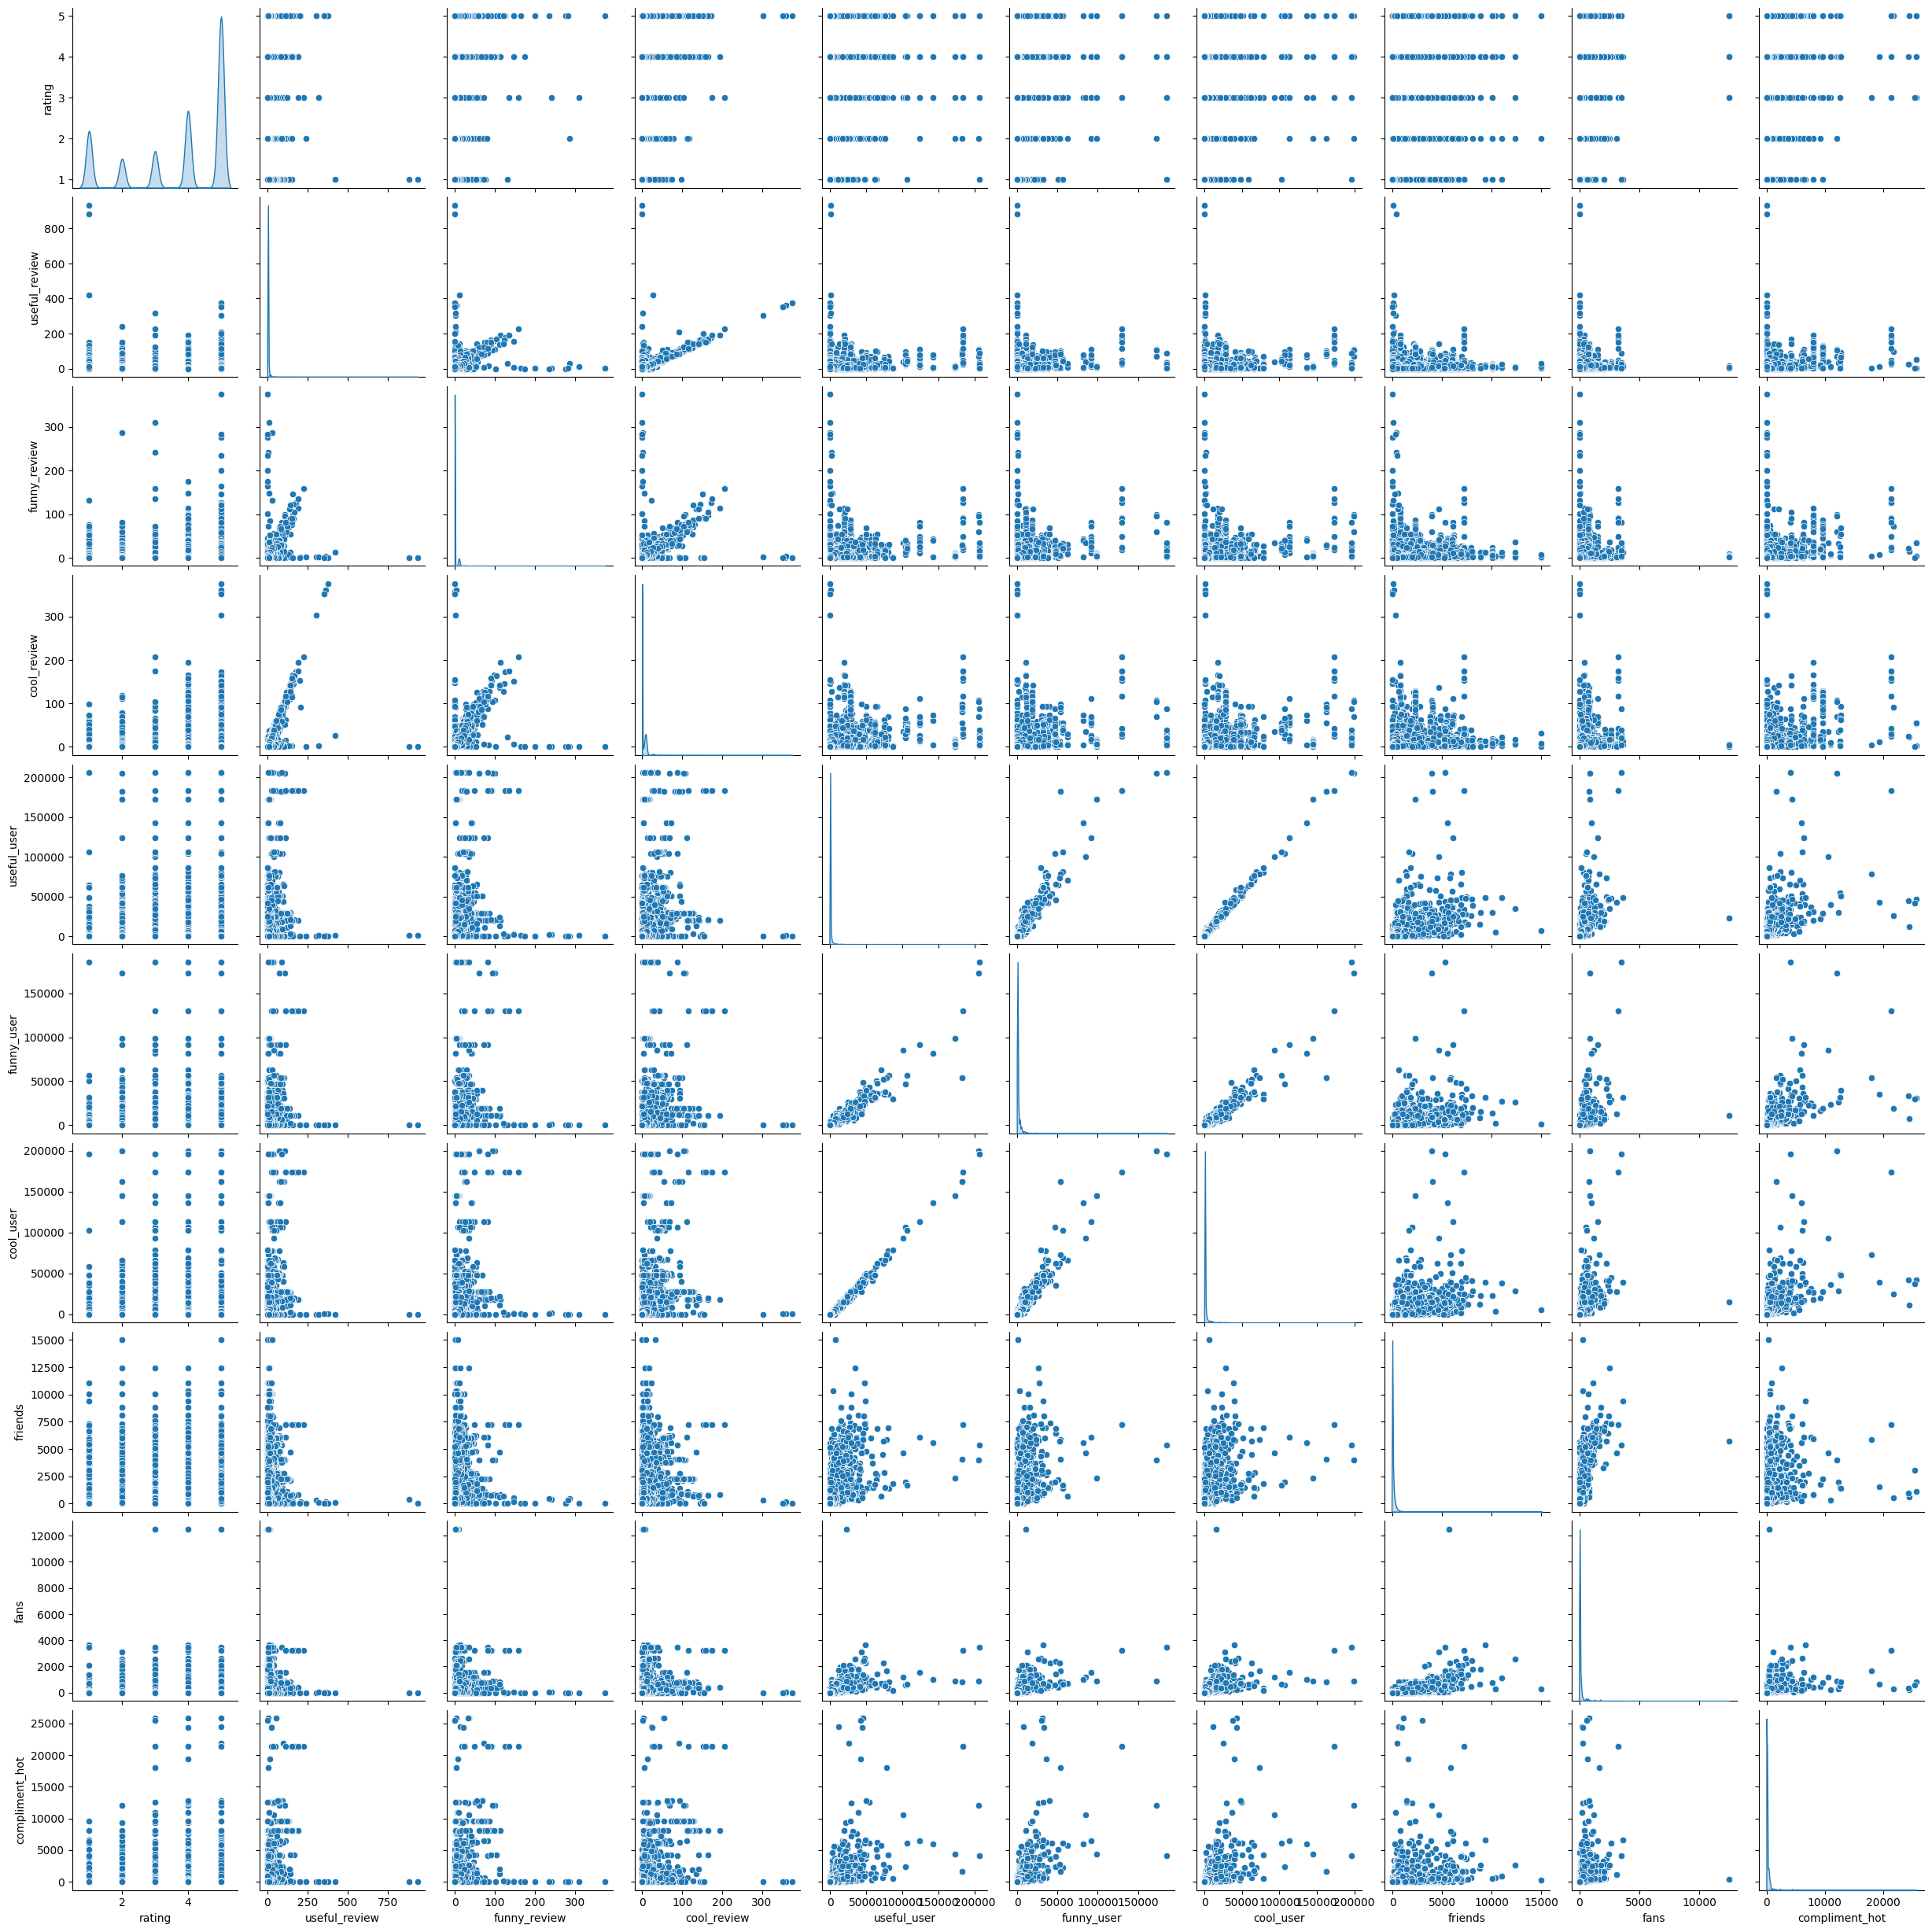

In [34]:
sns.pairplot(merged_reviews.iloc[:, :14], diag_kind="kde")
plt.show()

We can notice that for each feature there are a few major outliers that stand out. As a result, the data appears skewed to the left in the plots. We also notice that some features are more or less correlated. For example, the scatter plot of cool_user and useful_user is an almost straight line. Overall it seems that there is a pretty strong relationship between the different user "stats". The "stats" from the reviews also exhibit a similar behavior.


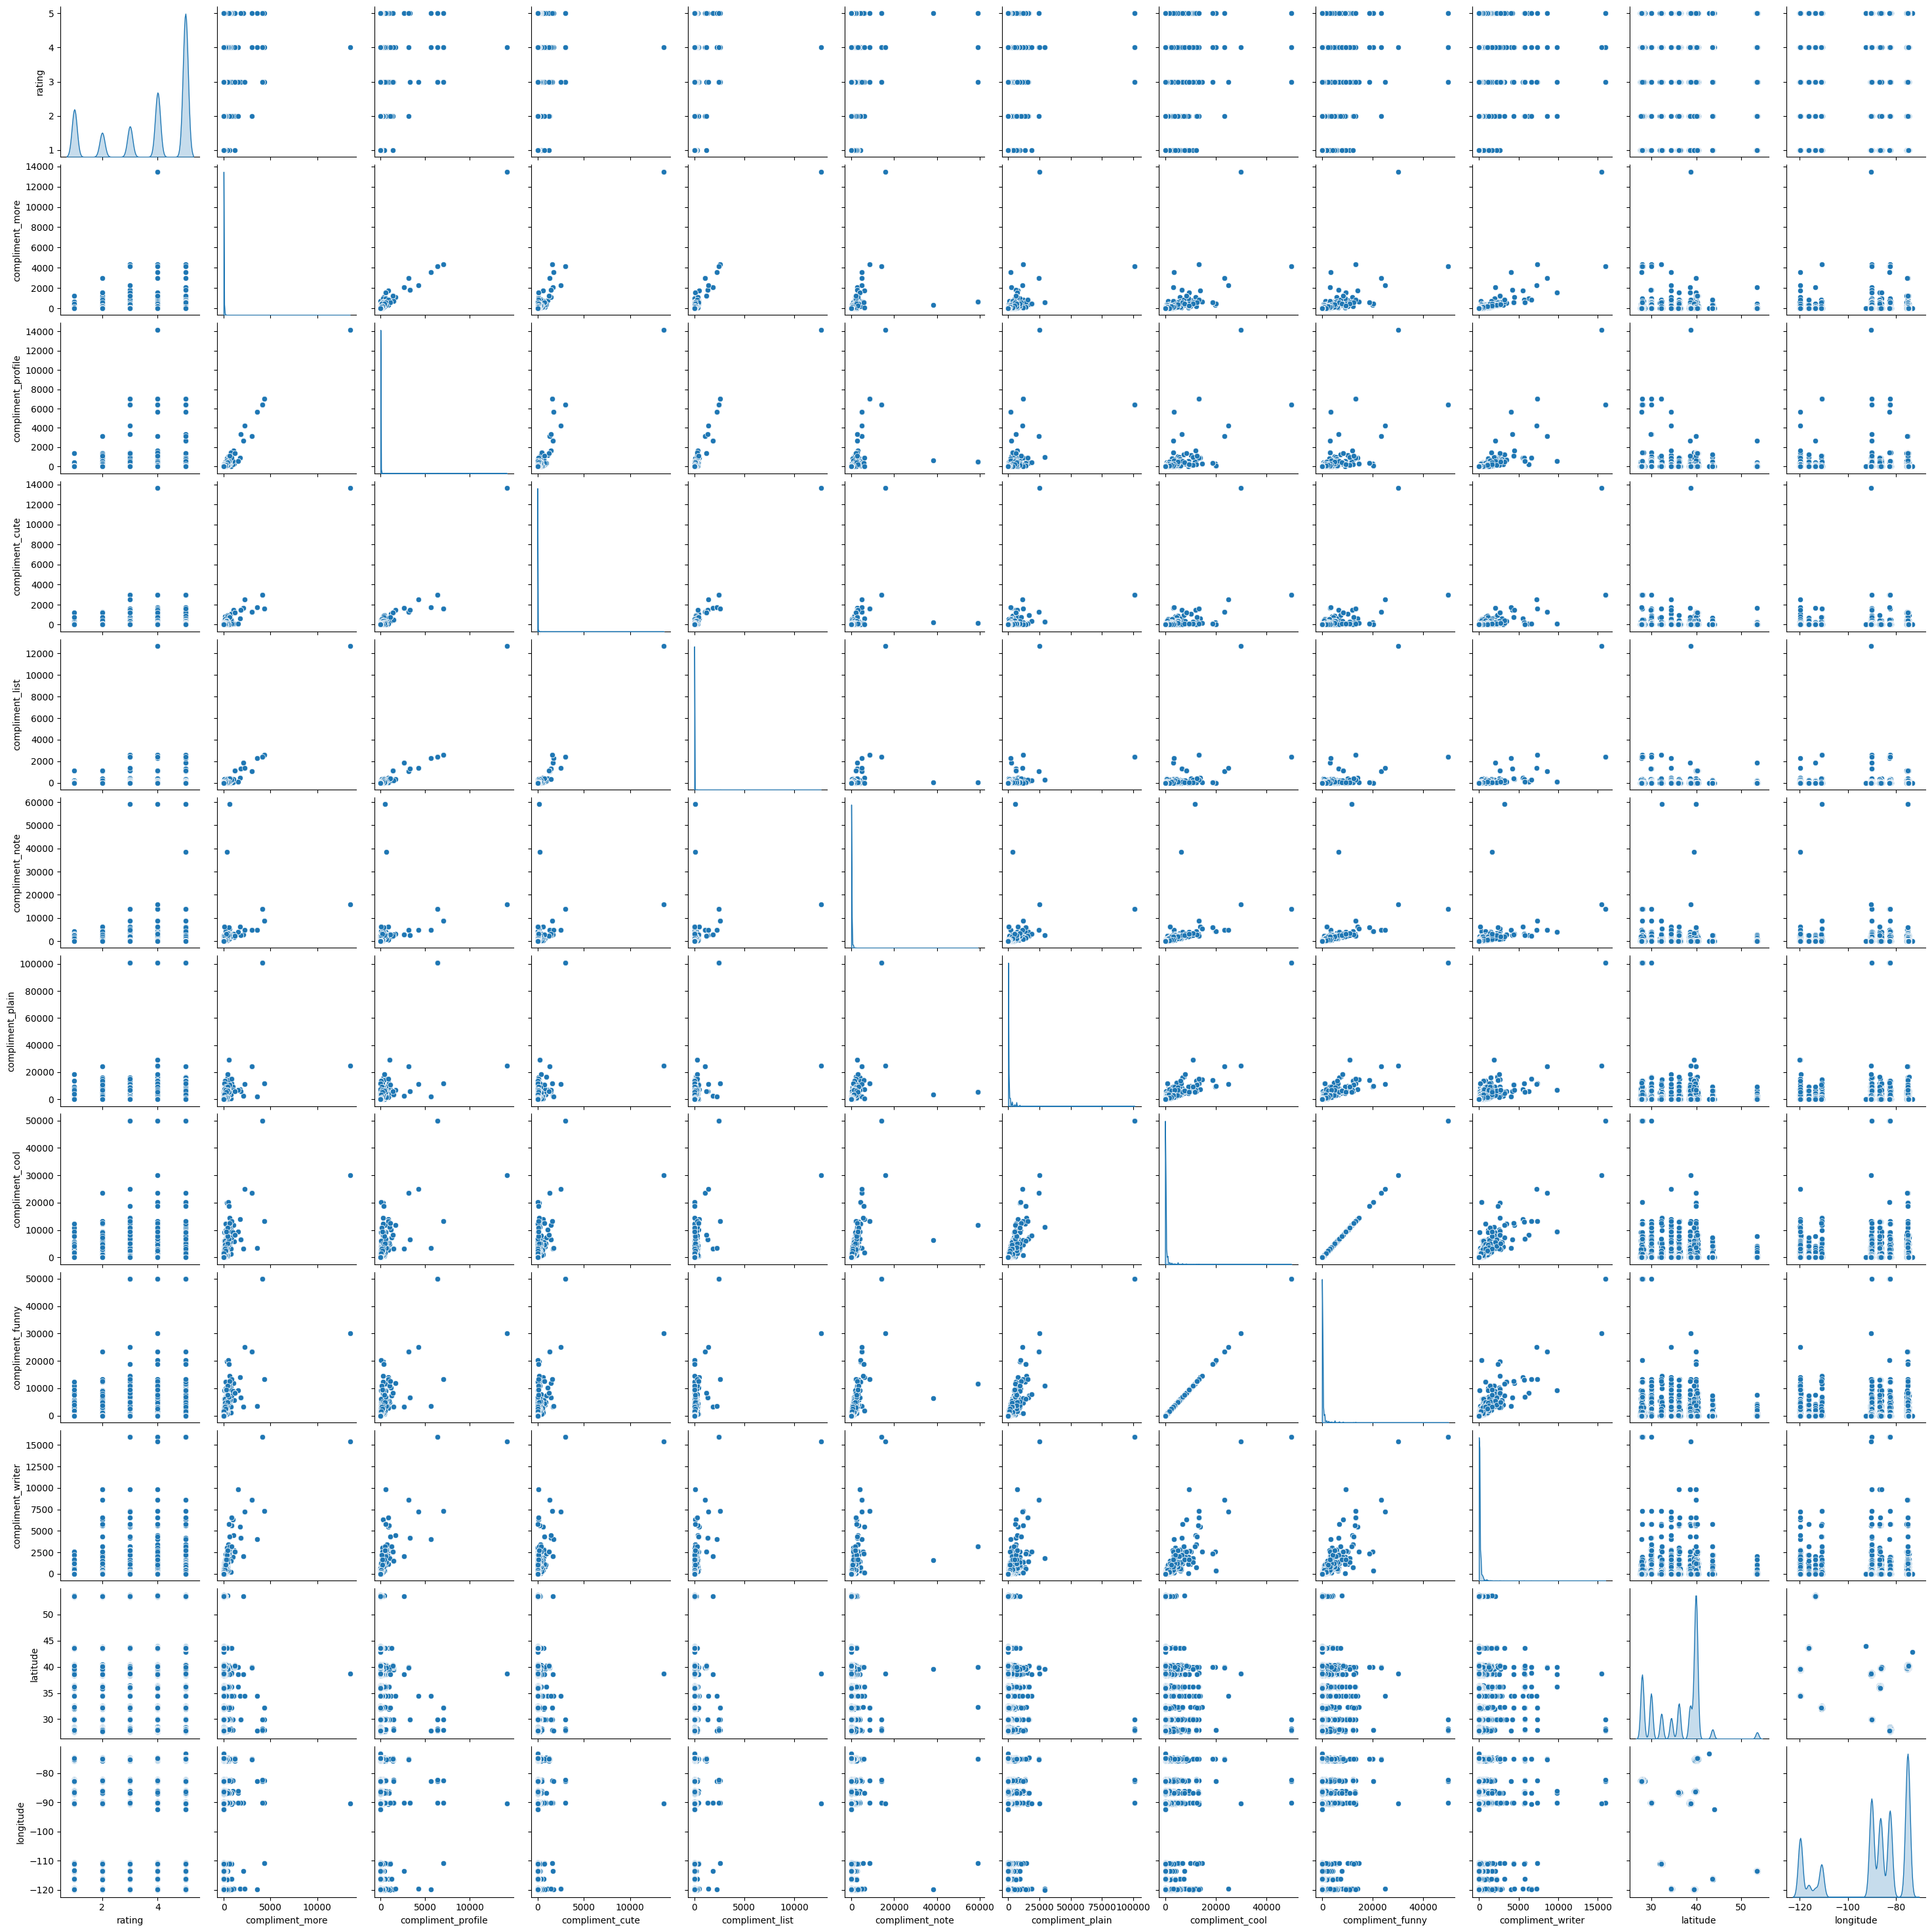

In [35]:
sns.pairplot(
    merged_reviews.iloc[:, [0] + list(range(14, merged_reviews.shape[1]))],
    diag_kind="kde",
)
plt.show()

compliment_funny and compliment_cool exhibit the strongest linear relationship among these variables.


### Correlations


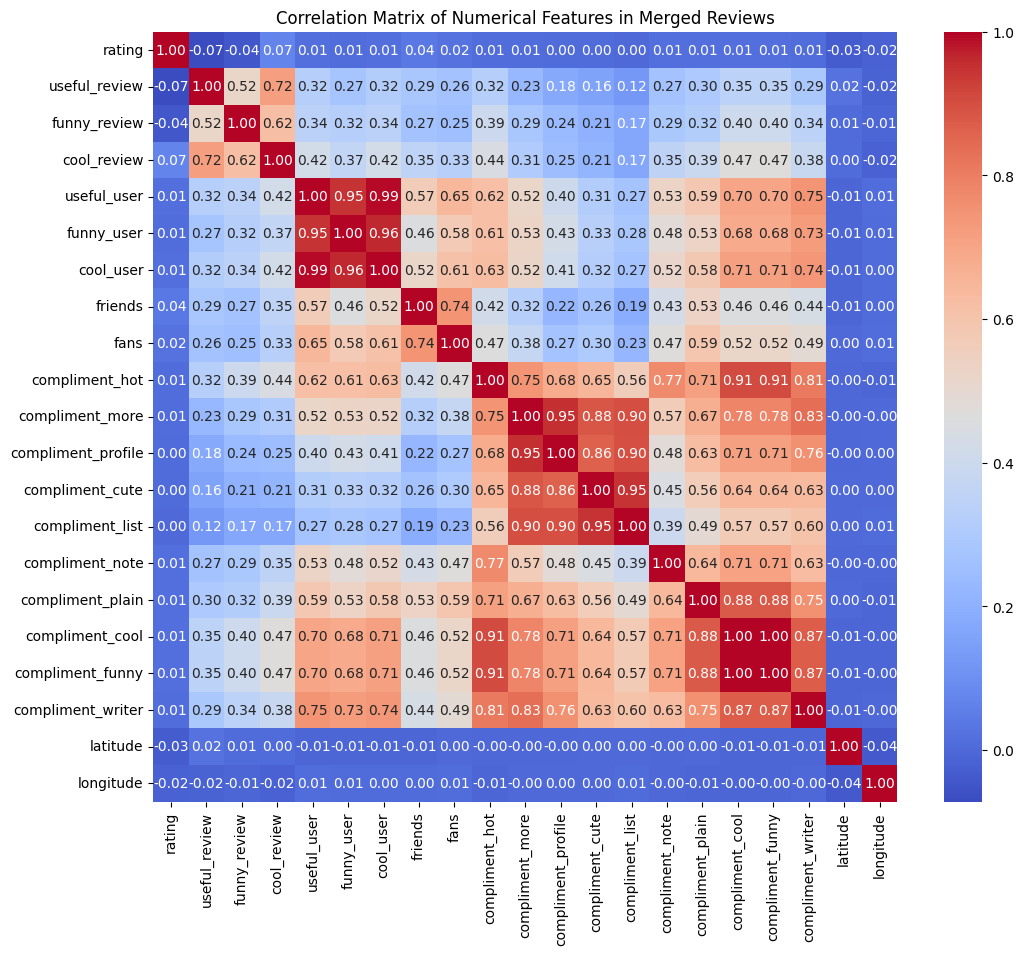

In [23]:
numerical_features = merged_reviews.select_dtypes(
    include=["int64", "float64", "int32", "float32"]
)


# Compute the correlation matrix

correlation_matrix = numerical_features.corr()


# Plot the correlation matrix

plt.figure(figsize=(12, 10))

sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numerical Features in Merged Reviews")

plt.show()

As expected, we notice strong correlations between some variables of the same nature (compliments-compliments, review-review, user-user). However, we also notice some strong correlations across variables of different nature such as compliment-user. Although weaker, there are other non-neligeable correlations accross the board. The lowest correlations are observed for latitude, longitude, and rating.


### The target variable


In [25]:
merged_reviews.rating.value_counts().iloc[
    0
] / merged_reviews.rating.value_counts().sum()

0.46178447073882467

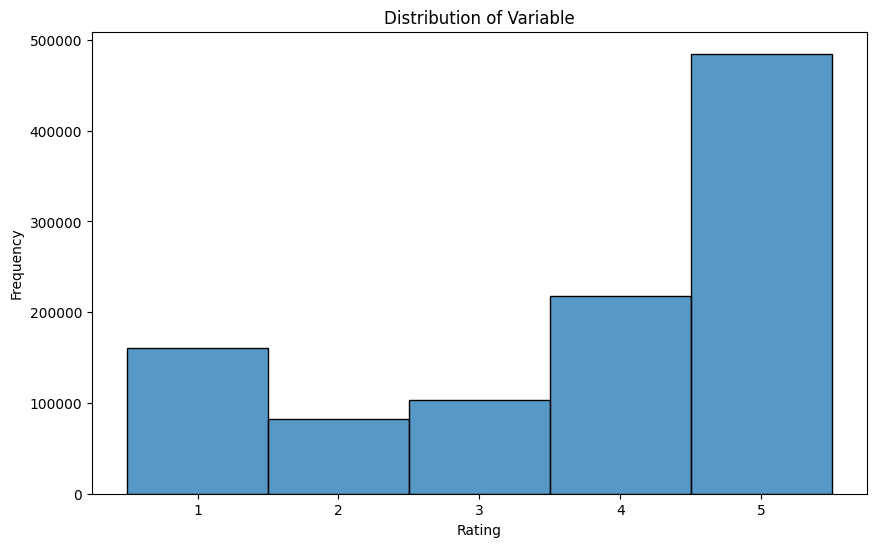

In [26]:
# Plotting the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(merged_reviews["rating"].astype("category"), kde=False)
plt.title("Distribution of Variable")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

We can clearly see that the different classes (ratings) are imbalanced. This might cause some issues when we will get to the predicting part since it leads to a bias towards the majority class. An evaluation metric such as the accuracy could be misleading since predicting everything as a rating of 5 leads to an accuracy of 46.18% which is much higher than 20%. Some techniques (sampling based or loss based) to deal with this imbalance might be necessary. As we saw from the scatterplots and the correlation matrix, it seems there is no clear relationship between the rating and any other numerical variable. Their relationship might be more intricate than a somple linear one, however.


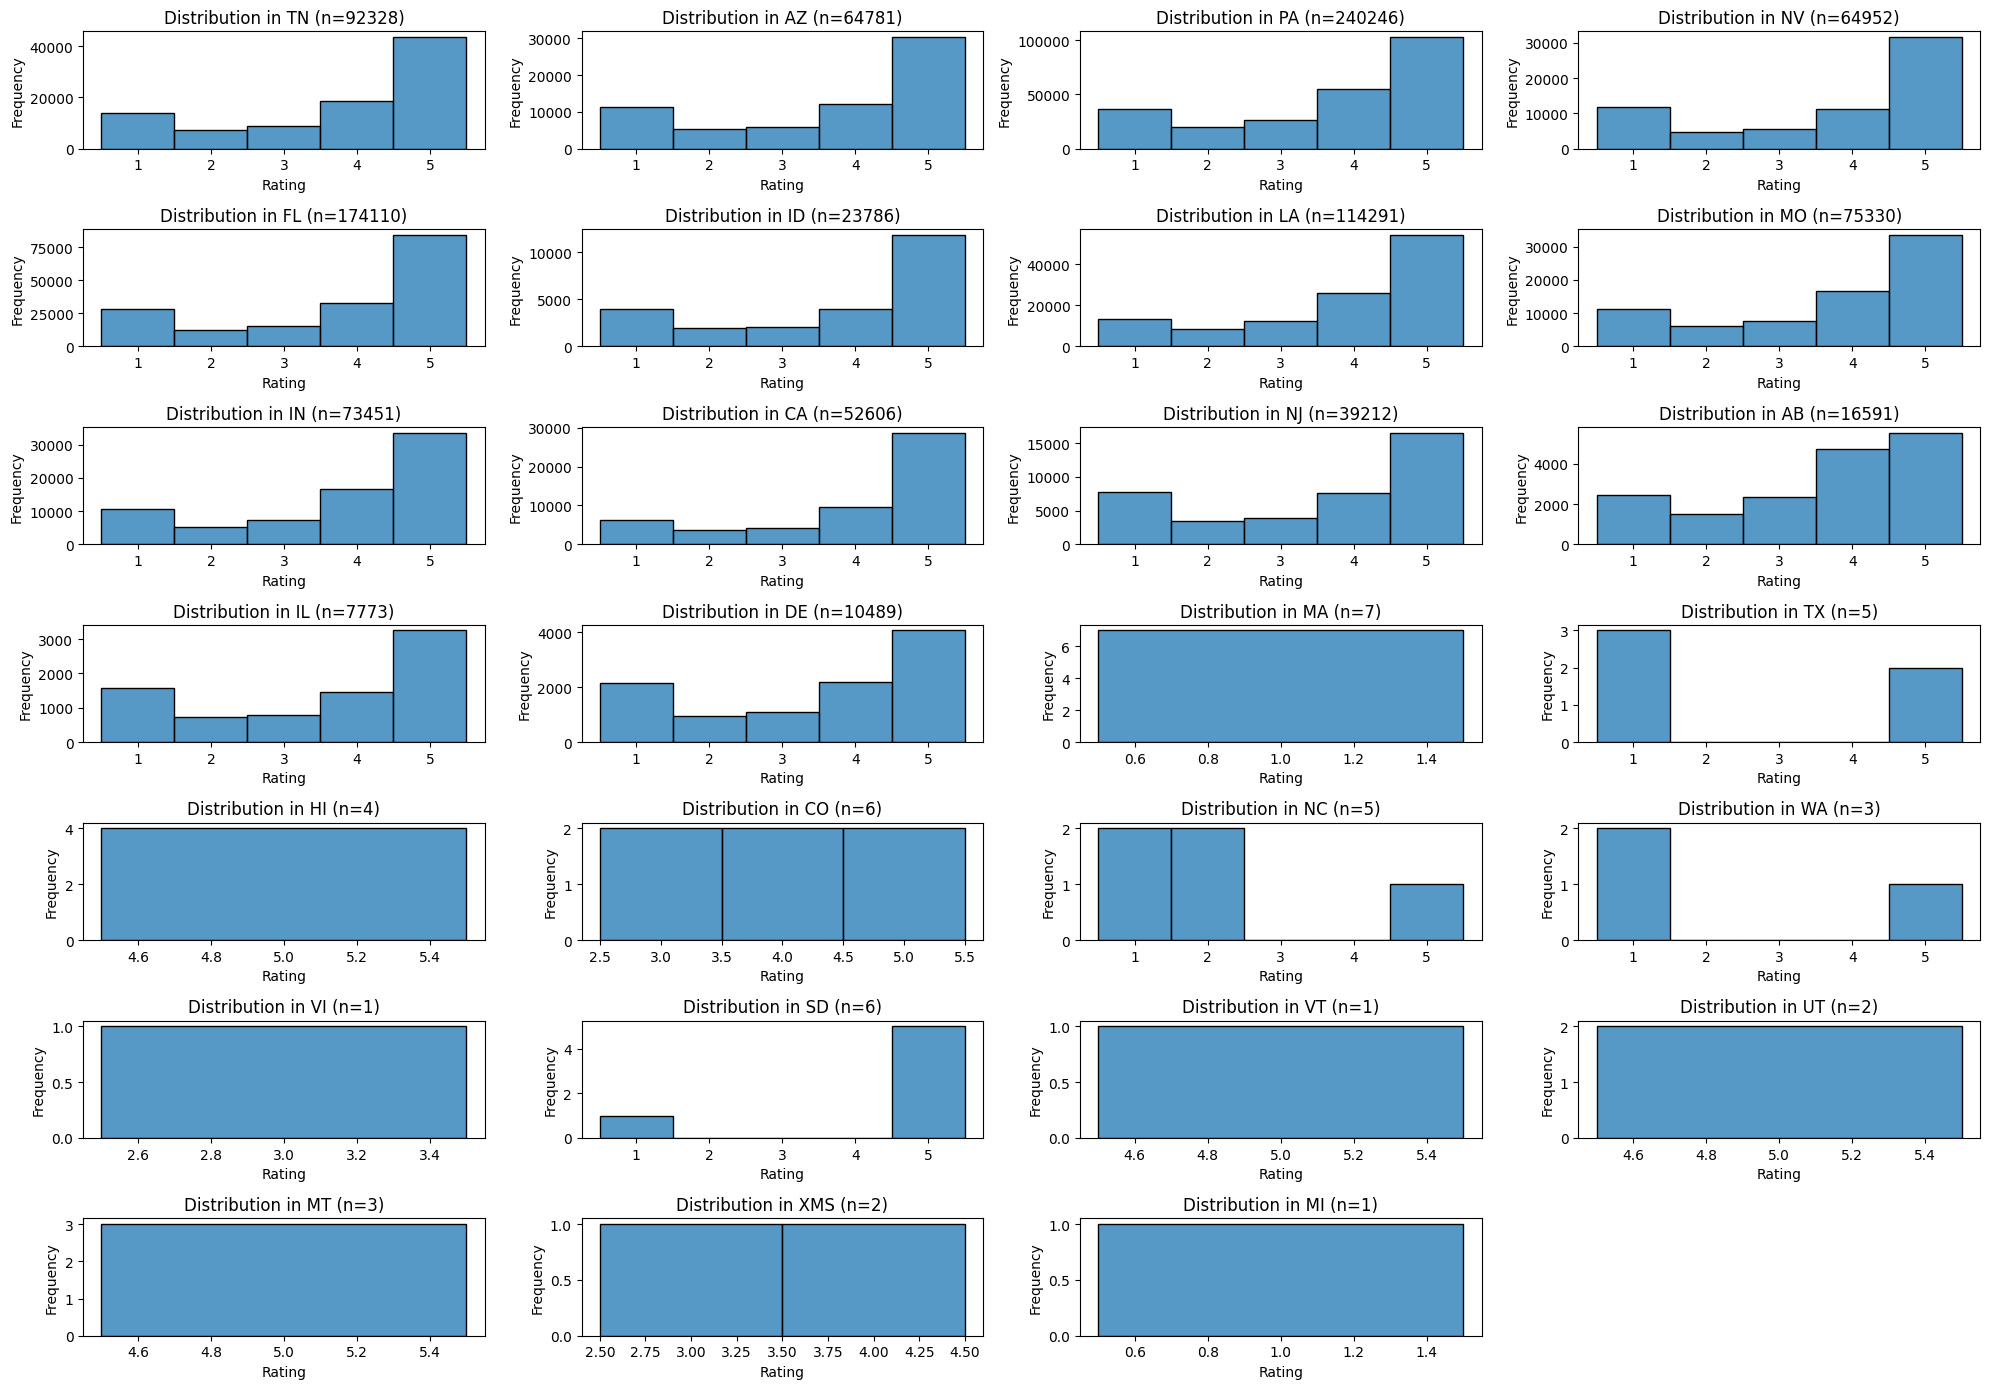

In [27]:
# Unique states
states = merged_reviews["state"].unique()
# Determine the number of rows needed for the subplot grid
n_rows = (len(states) + 3) // 4

# Create the subplots grid
fig, axes = plt.subplots(n_rows, 4, figsize=(20, 2 * n_rows))
axes = axes.flatten()

# Loop through the states and plot
for i, state in enumerate(states):
    sub_df = merged_reviews[merged_reviews["state"] == state]
    nb_reviews = sub_df.shape[0]
    sns.histplot(sub_df["rating"].astype("category"), kde=False, ax=axes[i])
    axes[i].set_title(f"Distribution in {state} (n={nb_reviews})")
    axes[i].set_xlabel("Rating")
    axes[i].set_ylabel("Frequency")

# If there are any remaining axes, turn them off
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

# Adjust the layout
plt.tight_layout()
plt.show()

The distribution of the ratings is uniform across the states. The distribution is different only when there are only a few reviews.


### The "text" feature


In [28]:
# Checking for any non-printable ASCII character
sub_df_ascii = merged_reviews[merged_reviews["text"].str.contains("[^ -~]", na=False)]
print(len(sub_df_ascii))

373565


There are 373565 reviews with characters such as "\n" indicating new lines. Depending on the model we might want to remove this.


# Feature Engineering


In [29]:
merged_reviews["n_days_open"] = merged_reviews.hours.str.count(
    "y'"
)  # Number of days the business is open

In [30]:
merged_reviews.groupby("n_days_open")["rating"].mean()

n_days_open
1.0    4.194326
2.0    3.923651
3.0    3.931155
4.0    4.060785
5.0    3.965339
6.0    3.945520
7.0    3.679843
Name: rating, dtype: float64

In [31]:
merged_reviews.rating.value_counts()

rating
5    484870
4    218095
1    161096
3    103784
2     82147
Name: count, dtype: int64

In [32]:
# Grouping the data by 'n_days_open' and extracting ratings
grouped_data = [
    group["rating"].values for name, group in merged_reviews.groupby("n_days_open")
]

# Performing Kruskal-Wallis Test
statistic, p_value = stats.kruskal(*grouped_data)

print("Kruskal-Wallis Statistic:", statistic)
print("P-Value:", p_value)

Kruskal-Wallis Statistic: 10983.990076572321
P-Value: 0.0


The medians seem to stastically differ assuming the samples are independent, so this variable could be a useful feature.


# Approach

1) The dataset is split into a training (80%) and testing set (20%) with no stratification as the sheer number of samples should allow us to get representative proportions of the different ratings. 
2) The models are fitted with their base parameters.
3) Basic assessment of the untuned model performance. 
3) Tuning of hyperparameters & fitting of the model.
4) Basic assessment of the tuned model performance.
5) Comparison between the models.

# Models

In [100]:
df_results = pd.DataFrame(columns=["Model", "Train MAE", "Test MAE"]) # Dataframe to store the results

## Transformer Based Model

### Embedding of the text feature - Google Gecko

To embed we will use Google's Gecko pretrained text embedder (text-embedding-004). The reason behind this choice is that this model accepts an argument ``task_type`` which helps the model produce better task-based embeddings. This is evidenced by the model's second-place performance in classification tasks within the <a href="https://huggingface.co/spaces/mteb/leaderboard">MTEB benchmark</a>. The model's highest dimensionality (with the best performance assoaciated) is 768. We're making the choice to use a smaller dimensionality to reduce subsequent computing times. The embeddings with a dimensionality of 256 also fairly high in the classification leaderboard, so it looks like a good compromise between performance and computation time.


Gecko leverages the knowledge of LLMs by generating synthetic data and refining it to create high-quality embeddings. This involves using an LLM to produce relevant query-passage pairs and then selecting the most informative positive and negative examples for training.

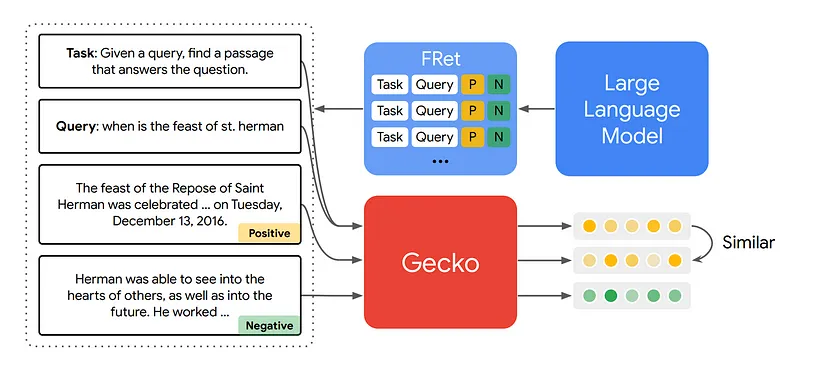

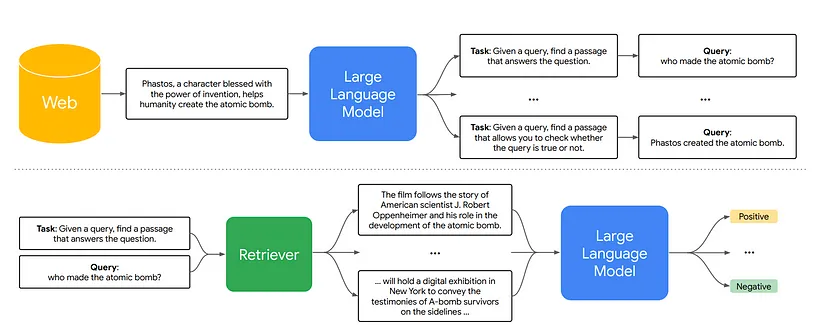

In [33]:
# !gcloud auth login

In [34]:
text_list = merged_reviews["text"].tolist()

# Function to call the Vertex AI API and embed the text
def embed_text(
    texts: List[str] = ["banana muffins? ", "banana bread? banana muffins?"],
    task: str = "CLASSIFICATION",
    model_name: str = "text-embedding-004",
    dimensionality: Optional[int] = 256,
) -> List[List[float]]:
    """Embeds texts with a pre-trained, foundational model."""
    model = TextEmbeddingModel.from_pretrained(model_name)
    inputs = [TextEmbeddingInput(text, task) for text in texts]
    kwargs = dict(output_dimensionality=dimensionality) if dimensionality else {}
    embeddings = model.get_embeddings(inputs, **kwargs)
    return [embedding.values for embedding in embeddings]

In [46]:
text_list_embeddings_256 = []
def batch_data(data, batch_size=80):
    """Yield successive batch-sized chunks from data."""
    for i in range(0, len(data), batch_size):
        yield data[i:i + batch_size]

data_batches = list(batch_data(text_list)) # Batching to stay within the API limits
for batch in tqdm(data_batches):
    while True: # Retry until the API call is successful (limited amount of calls per minute)
        try:
            text_list_embeddings_256.extend(embed_text(texts=batch, dimensionality=256))
            break
        except:
            time.sleep(10)

100%|██████████| 13125/13125 [9:05:23<00:00,  2.49s/it]   


In [24]:
# Save the embeddings
# pd.Series(text_list_embeddings_256).to_pickle("data/text_list_embeddings_256.pkl") 
text_list_embeddings_256 = pd.read_pickle("data/text_list_embeddings_256.pkl").tolist() #Loading the embeddings

In [25]:
targets = merged_reviews.rating.to_numpy(dtype=np.int32) # Get the ratings
text_list_embeddings_256 = np.array(text_list_embeddings_256,dtype=np.float32) # Convert to numpy array the embeddings

X_train, X_test, y_train, y_test = train_test_split(text_list_embeddings_256, targets, test_size=0.2, random_state=42) # Getting the train and test sets (not stratified since randomness should not have too big of an impact on this amount of data)

### LightGBM

LightGBM is a gradient boosting framework highly efficient due to its histogram-based algorithms, faster than traditional gradient boosting methods. It is robust to high dimensionality as well.

In [120]:
# Base parameters to get a rough estimate of the model's performance

# Initialize LightGBM Classifier model
base_lightgbm = lgb.LGBMClassifier(objective="multiclass",class_weight="balanced", random_state=42, n_jobs=-1) #Setting the class_weight to balanced to account for the imbalanced dataset

# Train the model
base_lightgbm.fit(X_train, y_train)

# Make predictions
y_pred_base_lgb = base_lightgbm.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.473613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65280
[LightGBM] [Info] Number of data points in the train set: 839993, number of used features: 256
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438


In [121]:
# Generate classification report
report = classification_report(y_test, y_pred_base_lgb)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           1       0.86      0.81      0.83     32373
           2       0.50      0.61      0.55     16456
           3       0.57      0.61      0.59     20726
           4       0.55      0.61      0.58     43268
           5       0.88      0.80      0.84     97176

    accuracy                           0.73    209999
   macro avg       0.67      0.69      0.68    209999
weighted avg       0.75      0.73      0.74    209999



It seems the models struggles the most with ratings between 2 and 4. This is expected since the reviews are going to be a mixed emotions unlike ratings of 1 and 5 that will be very polarized. The higher number of samples for ratings of 5 might also help the model classify these reivews more accurately. 

In [103]:
# Calculate Mean Absolute Error (MAE) on the training set
mae_train = mean_absolute_error(y_train, base_lightgbm.predict(X_train))
print("Mean Absolute Error (Ordinal Accuracy):", mae_train)

Mean Absolute Error (Ordinal Accuracy): 0.27434633383849627


In [122]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred_base_lgb)
print("Mean Absolute Error (Ordinal Accuracy):", mae)

Mean Absolute Error (Ordinal Accuracy): 0.2862680298477612


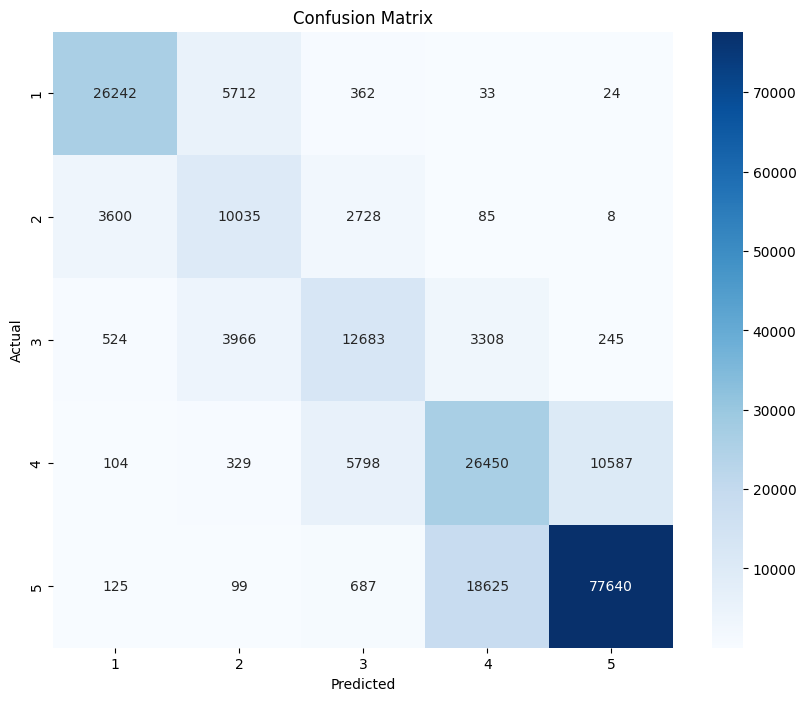

In [ ]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_base_lgb)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(targets), yticklabels=np.unique(targets))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Ratings of 1 are mostly mistaken for ratings of 2. This is good since this won't increase the ordinal accuracy too much. Similarly, ratings of 2 are mostly mistaken for ratings of 1 and ratings of 3. In fact, for each rating the class predicted wrongly is an adjacent one. This is expected since the adjacent ratings reflect similar levels of sentiment, making it more likely for the model to confuse them. 

In [105]:
new_row = pd.DataFrame([{"Model": "Gecko + Base LightGBM", "Train MAE": mae_train, "Test MAE": mae}])
df_results = pd.concat([df_results, new_row], ignore_index=True)

C:\Users\rodui\AppData\Local\Temp\ipykernel_17636\536405488.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, new_row], ignore_index=True)


#### Hyperparameters tuning

The tuning of hyperparameters is done using Optuna. It is a hyperparameter optimization framework that is very flexible. It is not an exhaustive gridsearch. Instead, it is based on algorithms such as Tree-structured Parzen Estimator  (TPE). This non-exhaustive search allows us to cast a wider net on the hyperparameters to test.

The hyperparameters chosen are:
- ``num_leaves``
    - The maximum number of leaves in each tree
    - Higher number leads to a more complex model with increased risk of overfitting
- ``min_data_in_leaf``:
    - The minmum number of observations that must be in a leaf
    - Lower number leads to a more complex model with increased risk of overfitting
- ``max_depth``:
    - The maximum depth of the tree
    - Higher number leads to a more complex model with increased risk of overfitting`
        - To prevent overfitting, the ``max_depth`` is limited to 9
- ``objective``: 
    - The loss function
        - Can be either a categorical crossentropy (``multiclass``) or a binary cross-entropy (One vs all binary classifier - ``multiclassova``)
- ``bagging_fraction``:
    - The fraction of data to be used for each iteration, subsampling of observations
    - Can prevent overfitting
- ``feature_fraction``:
    - The fraction of features to be used for each iteration
    - Can prevent overfitting
- ``class_weight``:
    - Attributing different weights to samples based on their class to penalize a missclassficiation of a minority more
    - Allows the model to pay more attention to underrepresented classes
- ``n_estimators``: 
    - Number of trees to be built (boosting rounds)
    - Higher number leads to a more complex model with increased risk of overfitting


In [36]:


stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

def objective_lightgbm(trial):
    # Suggest values for the hyperparameters
    num_leaves = trial.suggest_int('num_leaves', 31, 191, step=20)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 10, 190, step=20)
    max_depth = trial.suggest_int('max_depth', 1,9)
    objective = trial.suggest_categorical('objective', ['multiclass', 'multiclassova'])
    bagging_fraction = trial.suggest_float('bagging_fraction', 0.6, 1.0, step=0.1)
    feature_fraction = trial.suggest_float('feature_fraction', 0.6, 1.0, step=0.1)
    class_weight = trial.suggest_categorical('class_weight', ['balanced', None])
    n_estimators = trial.suggest_int('n_estimators', 50, 150, step=25)

    # Setup the LightGBM classifier
    classifier = lgb.LGBMClassifier(
        num_leaves=num_leaves,
        min_data_in_leaf=min_data_in_leaf,
        max_depth=max_depth,
        objective=objective,
        num_class=5,
        bagging_fraction=bagging_fraction,
        feature_fraction=feature_fraction,
        class_weight=class_weight,
        n_estimators=n_estimators,
        n_jobs=None
        )

    # Perform cross-validation
    score = cross_val_score(classifier, X_train, y_train, cv=stratified_kfold,n_jobs=7, scoring=mae_scorer).mean()

    return abs(score)

In [27]:
url = "sqlite:///data/optuna.db" #Store the trials

In [28]:
study = optuna.create_study(study_name="min_mae_lightgbm" ,direction='minimize', storage=url, load_if_exists=True) # Create a study

[I 2024-05-18 22:37:46,524] Using an existing study with name 'min_mae_lightgbm' instead of creating a new one.


In [37]:
study.optimize(objective_lightgbm, n_trials=30) # Optimize the study

[I 2024-05-18 23:05:44,252] Trial 71 finished with value: 0.26303790558872786 and parameters: {'num_leaves': 71, 'min_data_in_leaf': 190, 'max_depth': 9, 'objective': 'multiclass', 'bagging_fraction': 1.0, 'feature_fraction': 0.6, 'class_weight': None, 'n_estimators': 150}. Best is trial 58 with value: 0.26270218966610526.
[I 2024-05-18 23:10:21,470] Trial 72 finished with value: 0.26303790606067506 and parameters: {'num_leaves': 71, 'min_data_in_leaf': 190, 'max_depth': 9, 'objective': 'multiclass', 'bagging_fraction': 1.0, 'feature_fraction': 0.6, 'class_weight': None, 'n_estimators': 150}. Best is trial 58 with value: 0.26270218966610526.
[I 2024-05-18 23:14:09,824] Trial 73 finished with value: 0.26352481450032933 and parameters: {'num_leaves': 51, 'min_data_in_leaf': 170, 'max_depth': 9, 'objective': 'multiclass', 'bagging_fraction': 1.0, 'feature_fraction': 0.6, 'class_weight': None, 'n_estimators': 150}. Best is trial 58 with value: 0.26270218966610526.
[I 2024-05-18 23:18:40,03

In [39]:
# Sort the trials by MAE and display the parameters associated
sorted_trials = sorted(study.trials, key=lambda trial: trial.value)
for trial in sorted_trials:
    print(f"Trial {trial.number}: MAE = {trial.value}")
    print(f"Params: {trial.params}\n")

Trial 58: MAE = 0.26270218966610526
Params: {'num_leaves': 71, 'min_data_in_leaf': 190, 'max_depth': 8, 'objective': 'multiclass', 'bagging_fraction': 1.0, 'feature_fraction': 0.6, 'class_weight': None, 'n_estimators': 150}

Trial 84: MAE = 0.2627640936456784
Params: {'num_leaves': 71, 'min_data_in_leaf': 190, 'max_depth': 9, 'objective': 'multiclass', 'bagging_fraction': 1.0, 'feature_fraction': 0.6, 'class_weight': None, 'n_estimators': 150}

Trial 75: MAE = 0.2627998092579443
Params: {'num_leaves': 71, 'min_data_in_leaf': 190, 'max_depth': 9, 'objective': 'multiclass', 'bagging_fraction': 1.0, 'feature_fraction': 0.6, 'class_weight': None, 'n_estimators': 150}

Trial 91: MAE = 0.2628176669025097
Params: {'num_leaves': 71, 'min_data_in_leaf': 190, 'max_depth': 9, 'objective': 'multiclass', 'bagging_fraction': 1.0, 'feature_fraction': 0.6, 'class_weight': None, 'n_estimators': 150}

Trial 83: MAE = 0.2628426668727453
Params: {'num_leaves': 71, 'min_data_in_leaf': 190, 'max_depth': 9, 

After 100 trials, the best parameters are {'num_leaves': 71, 'min_data_in_leaf': 190, 'max_depth': 8, 'objective': 'multiclass', 'bagging_fraction': 1.0, 'feature_fraction': 0.6, 'class_weight': None, 'n_estimators': 150} <br>
The 3 CV mean abosulte error is 0.2627 <br>
The top scores all contain a subsampling of the dimensions (feature_fraction': 0.6). The top score is not the most complex model with a max_depth of 8. Not balancing the classes yields a better result. Since classification of the ratings 2,3,4 are less accurate it could be interesting increase the weights beyond "balanced" for these ratings.

In [106]:
best_params_lightgbm = study.best_params

#### Tuned Model Assessment

In [113]:

# Initialize LightGBM Classifier model
best_lightgbm = lgb.LGBMClassifier(**best_params_lightgbm, n_jobs=-1, random_state=42) #Setting the class_weight to balanced to account for the imbalanced dataset

# Train the model
best_lightgbm.fit(X_train, y_train)

# Make predictions
y_pred_lightgbm_best = best_lightgbm.predict(X_test)

[LightGBM] [Warning] min_data_in_leaf is set=190, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=190
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=190, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=190
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.396888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65280
[LightGBM] [Info] Number of data points in the train set: 839993, number 

In [114]:
# Generate classification report
report = classification_report(y_test, y_pred_lightgbm_best)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           1       0.81      0.89      0.85     32373
           2       0.56      0.47      0.51     16456
           3       0.62      0.56      0.59     20726
           4       0.63      0.52      0.57     43268
           5       0.83      0.91      0.87     97176

    accuracy                           0.76    209999
   macro avg       0.69      0.67      0.68    209999
weighted avg       0.75      0.76      0.75    209999



In [108]:
# Calculate Mean Absolute Error (MAE) on the training set
mae_train = mean_absolute_error(y_train, best_lightgbm.predict(X_train))
print("Mean Absolute Error (Ordinal Accuracy):", mae_train)

[LightGBM] [Warning] min_data_in_leaf is set=190, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=190
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
Mean Absolute Error (Ordinal Accuracy): 0.23003525029375244


In [115]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred_lightgbm_best)
print("Mean Absolute Error (Ordinal Accuracy):", mae)

Mean Absolute Error (Ordinal Accuracy): 0.25968695089024235


In [110]:
new_row = pd.DataFrame([{"Model": "Gecko + Best LightGBM", "Train MAE": mae_train, "Test MAE": mae}])
df_results = pd.concat([df_results, new_row], ignore_index=True)

### XGBoost

Like LightGBM, XGBoost uses a gradient boosting framework is a regular top performer. Unlike LightGBM however, XGBoost uses a level-wise tree growth strategy while LightGBM uses a leaf-wise tree growth strategy.

In [125]:
y_train_encoded = y_train - 1

# Initialize XGBoost model
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', seed=42, device='cuda')

# Train the model
model.fit(X_train, y_train_encoded)

# Make predictions
y_pred_base_xgb = model.predict(X_test)

y_pred_base_xgb += 1 

In [55]:
# Generate classification report
report = classification_report(y_test, y_pred_base_xgb)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           1       0.81      0.89      0.85     32373
           2       0.56      0.47      0.51     16456
           3       0.62      0.56      0.59     20726
           4       0.63      0.51      0.57     43268
           5       0.83      0.91      0.87     97176

    accuracy                           0.76    209999
   macro avg       0.69      0.67      0.68    209999
weighted avg       0.74      0.76      0.75    209999



Like LightGBM, the model struggles the most with rating between 2 and 4 (included). The metrics are slighlty higher however.

In [126]:
# Calculate Mean Absolute Error (MAE) on the training set
train_pred =model.predict(X_train)
train_pred += 1
mae_train = mean_absolute_error(y_train, train_pred)
print("Mean Absolute Error (Ordinal Accuracy):", mae_train)

Mean Absolute Error (Ordinal Accuracy): 0.23212455341889754


In [127]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred_base_xgb)
print("Mean Absolute Error (Ordinal Accuracy):", mae)

Mean Absolute Error (Ordinal Accuracy): 0.26187267558416943


As expected from the metrics, the ordinal accuracy also slightly better.

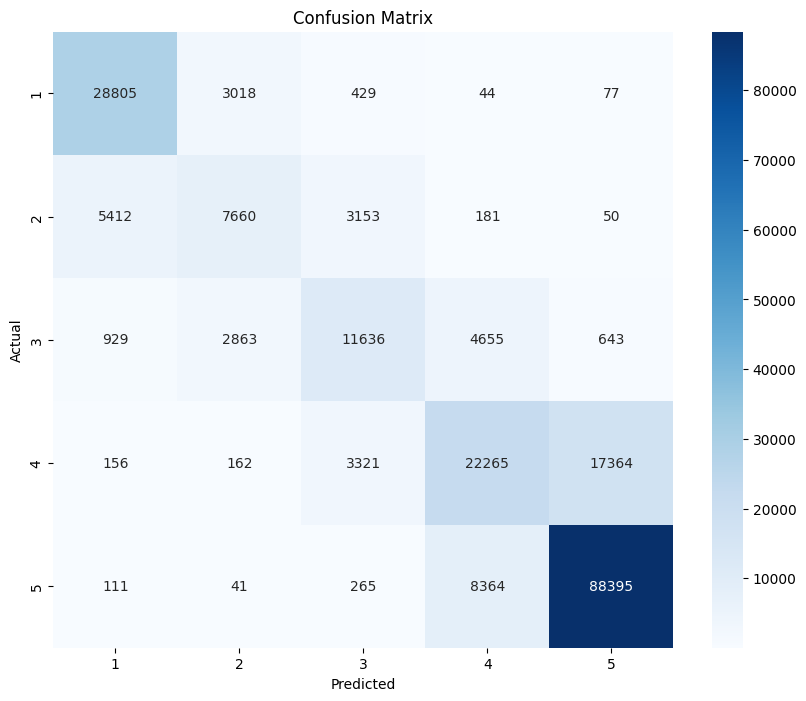

In [128]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_base_xgb)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(targets), yticklabels=np.unique(targets))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [129]:
new_row = pd.DataFrame([{"Model": "Gecko + Base XGBoost", "Train MAE": mae_train, "Test MAE": mae}])
df_results = pd.concat([df_results, new_row], ignore_index=True)

#### Hyperparameters tuning

The hyperparameters chosen are:
- ``max_depth``
    - The maximum depth of the trees
    - Higher number leads to a more complex model with increased risk of overfitting
- ``learning_rate``
    - The step size of each iteration toward minimizing the loss
    - A lower Learning rate can lead to a more robust model (prevent overfitting)
- ``subsample``
    - The fraction of the training data (observation sub-sampling) for each tree
    - Can prevent overfitting
- ``colsample_bytree``
    - The fraction of features sampled for each tree
    - Can help the model generalize (prevent overfitting)

In [60]:
y_train_encoded = y_train - 1

def objective_xgboost(trial):
    # Define the hyperparameters to be optimized
    param = {
        'objective': 'multi:softmax',
        'num_class': 5,  
        'max_depth': trial.suggest_int('max_depth', 3, 8),  
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 0.4, step=0.05),  
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1),
        'random_state': 42,
        "verbosity" : 0,
        'device': 'cuda'  
    }
    n_boosting_rounds = trial.suggest_int('rounds', 50, 200, step= 10)
    balanced = trial.suggest_categorical('balanced', [True, False])
    # Use Stratified K-Fold cross-validation
    stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True)
    
    scores = []
    
    for train_index, valid_index in stratified_kfold.split(X_train, y_train_encoded):
        X_train_cv, X_valid_cv = X_train[train_index], X_train[valid_index]
        y_train_cv, y_valid_cv = y_train_encoded[train_index], y_train_encoded[valid_index]
        
        if balanced:
            # Compute sample weights within the fold
            sample_weights_cv = compute_sample_weight(class_weight='balanced', y=y_train_cv)
            dtrain_cv = xgb.DMatrix(X_train_cv, label=y_train_cv, weight=sample_weights_cv)
        else:
            dtrain_cv = xgb.DMatrix(X_train_cv, label=y_train_cv)
        dvalid_cv = xgb.DMatrix(X_valid_cv, label=y_valid_cv)
        
        # Train the model
        bst = xgb.train(param, dtrain_cv, num_boost_round=n_boosting_rounds) 
        
        # Make predictions
        y_pred = bst.predict(dvalid_cv)
        y_pred += 1
        y_valid_cv += 1
        score = mean_absolute_error(y_valid_cv, y_pred)
        scores.append(score)
    
    return np.mean(scores)

In [61]:
study_xgboost = optuna.create_study(study_name="min_mae_xgboost" ,direction='minimize', storage=url, load_if_exists=True)

[I 2024-05-19 01:17:15,758] Using an existing study with name 'min_mae_xgboost' instead of creating a new one.


In [63]:
study_xgboost.optimize(objective_xgboost, n_trials=100)

[I 2024-05-19 01:27:01,039] Trial 22 finished with value: 0.26356052964064797 and parameters: {'max_depth': 7, 'learning_rate': 0.15000000000000002, 'subsample': 0.7, 'colsample_bytree': 1.0, 'rounds': 180, 'balanced': False}. Best is trial 18 with value: 0.26338076626053336.
[I 2024-05-19 01:30:26,600] Trial 23 finished with value: 0.26482482557610787 and parameters: {'max_depth': 6, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.9, 'rounds': 190, 'balanced': False}. Best is trial 18 with value: 0.26338076626053336.
[I 2024-05-19 01:35:13,989] Trial 24 finished with value: 0.26782485158399577 and parameters: {'max_depth': 8, 'learning_rate': 0.2, 'subsample': 0.5, 'colsample_bytree': 1.0, 'rounds': 160, 'balanced': False}. Best is trial 18 with value: 0.26338076626053336.
[I 2024-05-19 01:39:33,451] Trial 25 finished with value: 0.2635355293090113 and parameters: {'max_depth': 7, 'learning_rate': 0.15000000000000002, 'subsample': 0.6, 'colsample_bytree': 1.0, 'rounds': 

In [64]:
# Sort the trials by MAE and display the parameters associated
sorted_trials_xgboost = sorted(study_xgboost.trials, key=lambda trial: trial.value)
for trial in sorted_trials_xgboost:
    print(f"Trial {trial.number}: MAE = {trial.value}")
    print(f"Params: {trial.params}\n")

Trial 93: MAE = 0.26251409145603255
Params: {'max_depth': 8, 'learning_rate': 0.15000000000000002, 'subsample': 1.0, 'colsample_bytree': 0.8, 'rounds': 200, 'balanced': False}

Trial 105: MAE = 0.26252242654109725
Params: {'max_depth': 8, 'learning_rate': 0.15000000000000002, 'subsample': 1.0, 'colsample_bytree': 0.8, 'rounds': 200, 'balanced': False}

Trial 103: MAE = 0.2625379022766321
Params: {'max_depth': 8, 'learning_rate': 0.15000000000000002, 'subsample': 1.0, 'colsample_bytree': 0.8, 'rounds': 200, 'balanced': False}

Trial 86: MAE = 0.26257242560995436
Params: {'max_depth': 8, 'learning_rate': 0.15000000000000002, 'subsample': 1.0, 'colsample_bytree': 0.8, 'rounds': 200, 'balanced': False}

Trial 107: MAE = 0.26258313995944443
Params: {'max_depth': 8, 'learning_rate': 0.15000000000000002, 'subsample': 1.0, 'colsample_bytree': 0.8, 'rounds': 200, 'balanced': False}

Trial 63: MAE = 0.2626283794662689
Params: {'max_depth': 8, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_by

After ~120 trials, the best parameters are: 
Params: {'max_depth': 8, 'learning_rate': 0.15, 'subsample': 1.0, 'colsample_bytree': 0.8, 'rounds': 200, 'balanced': False}

The 3 CV mean absolute error is ranging from 0.26258 to 0.26251. Similarly to LightGBM, a sample of features is taken.

In [92]:
params_xgboost = study_xgboost.best_params
del params_xgboost['balanced'] # Not an official hyperparameter of XGBoost

#### Tuned Model Assessment

In [130]:

# Initialize XGBoost model
bst_xgb = XGBClassifier(**params_xgboost, seed=42, device='cuda')

# Train the model
bst_xgb.fit(X_train, y_train_encoded)

# Make predictions
y_pred_best_xgb = bst_xgb.predict(X_test)

y_pred_best_xgb += 1 

In [131]:
# Generate classification report
report = classification_report(y_test, y_pred_best_xgb)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           1       0.81      0.89      0.85     32373
           2       0.56      0.46      0.51     16456
           3       0.62      0.56      0.59     20726
           4       0.63      0.51      0.56     43268
           5       0.83      0.91      0.87     97176

    accuracy                           0.76    209999
   macro avg       0.69      0.67      0.68    209999
weighted avg       0.74      0.76      0.75    209999



The clssification metrics are pretty much the same as with the untuned model.

In [132]:
# Calculate Mean Absolute Error (MAE) on the training set
train_pred =bst_xgb.predict(X_train)
train_pred += 1
mae_train = mean_absolute_error(y_train, train_pred)
print("Mean Absolute Error (Ordinal Accuracy):", mae_train)

Mean Absolute Error (Ordinal Accuracy): 0.2165768048067067


In [133]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred_best_xgb)
print("Mean Absolute Error (Ordinal Accuracy):", mae)

Mean Absolute Error (Ordinal Accuracy): 0.261101243339254


The training MAE is much lower and the test MAE is very slightly lower compared to the untuned model.

In [134]:
new_row = pd.DataFrame([{"Model": "Gecko + Best XGBoost", "Train MAE": mae_train, "Test MAE": mae}])
df_results = pd.concat([df_results, new_row], ignore_index=True)

# Models Comparison 


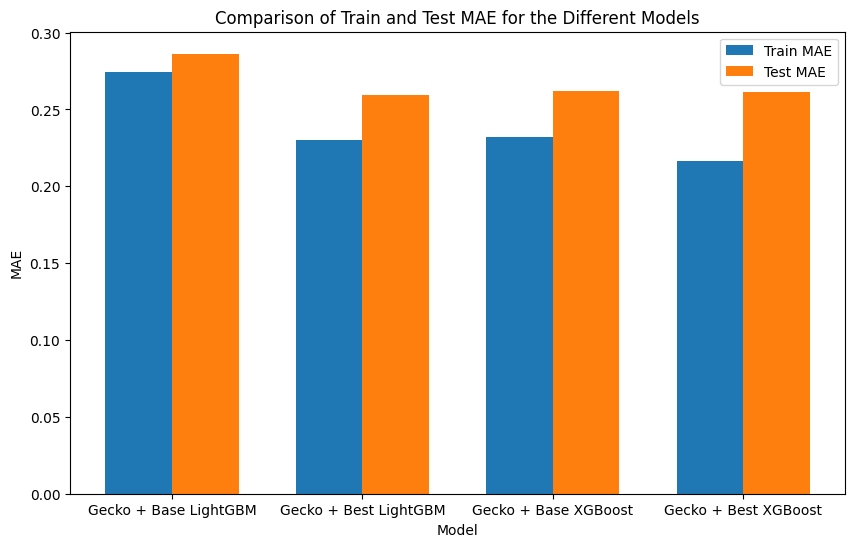

In [135]:
# Plotting the clustered bar plot
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
index = range(len(df_results))

bar1 = ax.bar(index, df_results['Train MAE'], bar_width, label='Train MAE')
bar2 = ax.bar([i + bar_width for i in index], df_results['Test MAE'], bar_width, label='Test MAE')

ax.set_xlabel('Model')
ax.set_ylabel('MAE')
ax.set_title('Comparison of Train and Test MAE for the Different Models')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(df_results['Model'])
ax.legend()

plt.show()

The comparison between the models is baseed on their performance regarding the metric. For the tuning
$$
\text{Ordinal Accuracy} = \frac{1}{n_t} \sum_{i=1}^{n_t} \left| \hat{y}_i - y_i \right|,
$$

where $y_i ∈ {1, 2, 3, 4, 5}$ are the true customer ratings and $\hat{y}_i ∈ {1, 2, 3, 4, 5}$ are the predictions. As expected the training erorr is lower since the model has seen the data the error is calculated on. However, the magnitude of this difference varies. The models using 
A big difference could indicate overfitting. For the models using ``text-embedding-gecko``, LightGBM benefits more from the hypertuning of parameters than XGBoost as we can see from the difference in error between the tuned and untuned models. The model with the smallest error on the test set is the model with Gecko text embeddings combined with the tuned LightGBM. The model with lowest train error is Gecko + tuned XGBoost. The tuning reduced the training error noticeably, but the test error was barely improved. This could indicate a slight overfitting. The hyperparameters could perhaps be better chosen. 

# Best Model Assessment

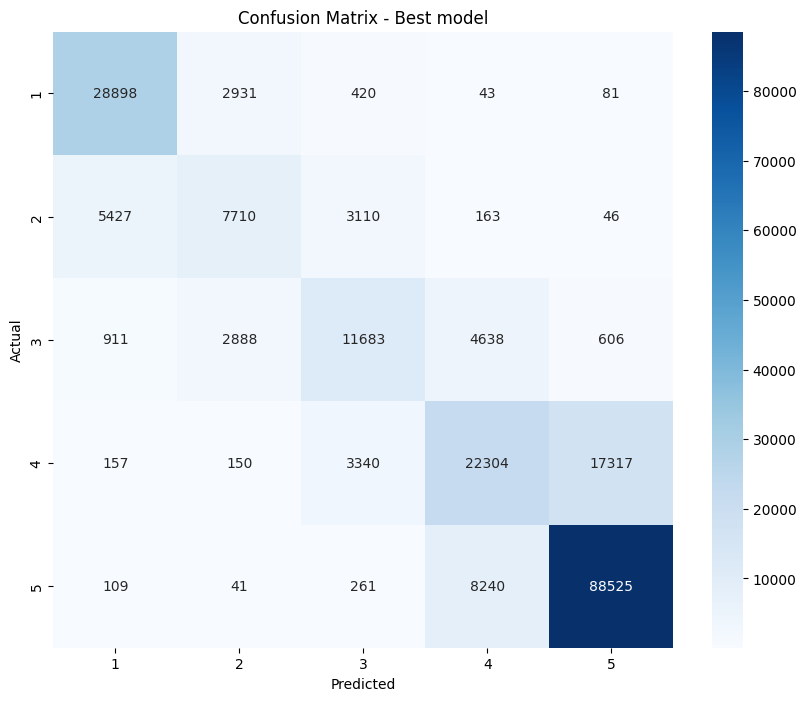

In [119]:
# Plot the confusion matrix
conf_matrix_lightgbm_best = confusion_matrix(y_test, y_pred_lightgbm_best)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_lightgbm_best, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(targets), yticklabels=np.unique(targets))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Best model')
plt.show()

In [140]:
report_lightgbm_best = classification_report(y_test, y_pred_lightgbm_best)
print("Classification Report - Best model:\n", report_lightgbm_best)

Classification Report - Best model:
               precision    recall  f1-score   support

           1       0.81      0.89      0.85     32373
           2       0.56      0.47      0.51     16456
           3       0.62      0.56      0.59     20726
           4       0.63      0.52      0.57     43268
           5       0.83      0.91      0.87     97176

    accuracy                           0.76    209999
   macro avg       0.69      0.67      0.68    209999
weighted avg       0.75      0.76      0.75    209999



For each rating, the true rating has the most predictions. When the rating is false, it mistaken most of the time with the adjacent rating.The further away a rating is from the true rating, the lower the number of FP. However, the model struggles with rating between 2 and 4 included. We can see that the recall on the rating of 2 is below 50% meaning that less than 50% of the ratings have been detected. It is also lowest precision at 0.52. This means that 48% of ratings 2 are not actually ratings 2. What is also striking is that the ratings of 4 are much more mistaken for ratings of 5 rather than ratings of 3 (17317 vs 3340). This is not a recurrent pattern. Indeed, ratings of 2 are mostly mistaken with ratings of 1, and although ratings of 3 are mostly mistaken for ratings of 4, the ratio is not as big (4638 vs 2888). <br>
The balanced accuracy is 67%, and the accuracy is 76%.

## Additonal Considerations


Other variables from the dataset could be included if allowed. They could be concatened with the text embeddings as additional dimensions. For example, including the number "useful" for a review could look like $[x,y_1,y_2,y_3]$ where x is the number of useful and y's are the dimensions of the text embeddings. Categorical could be encoded and considered as categorical (model parameter) and added in the same way. A normalization of some could be needed before the concatenation. Features engineered from the "text" variable could also be included. For example, the text length could be added in to array as a dimension. Regarding the tuning of hyperparameters, custom wieghts could be chosen.

# Submission


In [31]:


# test_reviews = pd.read_parquet(r"data\ATML2024_reviews_test.parquet")
# test_reviews= test_reviews["text"].tolist()
# reviews_embeddings_256 = []
# # data_batches = list(batch_data(test_reviews)) # Batching to stay within the API limits
# # for batch in tqdm(data_batches):
# #     while True: # Retry until the API call is successful (limited amount of calls per minute)
# #         try:
# #             reviews_embeddings_256.extend(embed_text(texts=batch, dimensionality=256))
# #             break
# #         except:
# #             time.sleep(10)


# Getting the embedding of the reviews from the test dataset
reviews_embeddings = pd.read_pickle(r"data\embeddings_submission.pkl").to_list()
reviews_embeddings = np.array(reviews_embeddings, dtype=np.float32)


# Train the model with all the data using the best hyperparameters
# Initialize LightGBM Classifier model
best_lightgbm_full = lgb.LGBMClassifier(**best_params_lightgbm, n_jobs=-1) #Setting the class_weight to balanced to account for the imbalanced dataset

# Train the model
best_lightgbm_full.fit(text_list_embeddings_256, targets)

# Predict the ratings
y_pred_submission = best_lightgbm_full.predict(reviews_embeddings)


[LightGBM] [Warning] min_data_in_leaf is set=190, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=190
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=190, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=190
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.651127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65280
[LightGBM] [Info] Number of data points in the train set: 1049992, number

In [98]:
# Create a DataFrame
df_submission = pd.DataFrame({
    'id': range(0, len(y_pred_xgb) ),
    'rating': y_pred_xgb
})

# Save to CSV
df_submission.to_csv('submission_xgb.csv', index=False)